In [250]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sps
import csv

# Load and Preprocess Data

In [251]:
# イベントデータの取得用関数
def read_event_data(DATADIR, game_id):
    filename = f"/Sample_Game_{game_id}/Sample_Game_{game_id}_RawEventsData.csv"
    events = pd.read_csv(DATADIR + filename)

    return events


# teamname(Home or Away)のトラッキングデータの取得関数
def read_tracking_data(DATADIR, game_id, teamname):
    # teamnameがHomeでもAwayでもなければ終了
    assert teamname in ["Home", "Away"], "teamname must be \"Home\" or \"Away\"."

    filename = f"/Sample_Game_{game_id}/Sample_Game_{game_id}_RawTrackingData_{teamname}_Team.csv"
    # カラム名を定義するためにcsv.readerを定義
    csvfile = open(DATADIR + filename)
    reader = csv.reader(csvfile)
    # 1行目4列目のチーム名を取得
    teamnamefull = next(reader)[3].lower()
    # 2行目の背番号を取得
    jerseys = [jersey for jersey in next(reader) if jersey != ""]
    # 3行目をカラム名として取得
    columns = next(reader)
    # 背番号ごとのx-y座標を表現するように列名を置換
    for index, jersey in enumerate(jerseys):
        columns[index*2+3] = f"{teamname}_{jersey}_x"
        columns[index*2+4] = f"{teamname}_{jersey}_y"
    # ボール位置のx-y座標を表現するように列名を置換
    columns[-2] = "ball_x"
    columns[-1] = "ball_y"

    # 4行目以降のデータを取得
    tracking = pd.read_csv(DATADIR + filename, names=columns, index_col="Frame", skiprows=3)

    return tracking


# 座標系の変更
# 変更前
# 原点：左上コーナーフラッグ  x軸：サイドライン(0～1)  y軸：エンドライン(0～1)
# 変更後
# 原点：センターマーク       x軸：ホームチーム攻撃方向(m)   y軸：ハーフウェイライン(m)
def to_metric_coordinates(data, field_size_m=(106., 68.)):

    # dataのcolumnの最後の文字がxかyの列を取得
    x_columns = [column for column in data.columns if column[-1].lower()=="x"]
    y_columns = [column for column in data.columns if column[-1].lower()=="y"]
    # データがおおよそ[0,1]の範囲になければ終了
    xy_max = np.max([data[x_columns].max().max(), data[y_columns].max().max()])
    xy_min = np.min([data[x_columns].min().min(), data[y_columns].min().min()])
    assert 0 <= np.round(xy_min) and np.round(xy_max) <= 1, "aaa"

    # 座標変更
    data[x_columns] = (data[x_columns] - 0.5)*field_size_m[0]
    data[y_columns] = -1*(data[y_columns] - 0.5)*field_size_m[1]

    return data


# 前後半合わせてホームチームがx軸プラス方向に攻撃するように変更
def to_single_playing_direction(events, home, away):
    # キックオフ時点でのホームチームの攻撃方向を特定
    Kickoff_frame = events.loc[0]["Start Frame"]
    home_x_columns = [column for column in tracking_home.columns if column[-1].lower()=="x"]
    home_playing_direction = -1*np.sign(tracking_home[home_x_columns].iloc[Kickoff_frame].mean())

    for data in [events, home, away]:
        # 後半(Period=2)が始まるindexを特定
        second_half_index = data.Period.idxmax()
        # 変更が必要なカラムを特定
        xy_columns = [column for column in data.columns if column[-1].lower() in ["x", "y"]]
        # ホームチームがx軸プラス方向に攻撃するように置換
        data[xy_columns] *= home_playing_direction
        # 後半の攻撃方向を置換
        data.loc[second_half_index:, xy_columns] *= -1

    return events, home, away


# 選手とボールの速度を測定
def calculate_velocities(tracking_team, smoothing=True, window=7, polyorder=1, player_maxspeed=12):
    # 予め計算されている速度データを削除
    v_columns = [column for column in tracking_team.columns if column.split("_")[-1] in ["vx", "vy", "speed"]]
    tracking_team = tracking_team.drop(v_columns)
    # Home or Awayで始まるカラムについて、_x or _yを削除して格納
    team_jerseys = np.unique([column[:-2] for column in tracking_team.columns if column[:4] in ["Home", "Away"]])
    # ボールを含めた選手を動体として格納
    moving_objects = list(team_jerseys) + ["ball"]
    # レコードごとの時間差分を取得
    dt = tracking_team["Time [s]"].diff()
    # 後半(Period=2)が始まるindexを特定
    second_half_index = tracking_team.Period.idxmax()

    for index, moving_object in enumerate(moving_objects):
        # x, y方向の速度を計算
        vx = tracking_team[f"{moving_object}_x"].diff() / dt
        vy = tracking_team[f"{moving_object}_y"].diff() / dt
        # 最大速度以上の場合はnanに置換
        if  moving_object in team_jerseys and player_maxspeed > 0:
            speed = np.sqrt(vx**2 + vy**2)
            vx[speed > player_maxspeed] = np.nan
            vy[speed > player_maxspeed] = np.nan
        # Savitzky-Golayフィルタでフィルタリング
        if smoothing:
            # 前半
            vx.loc[:second_half_index] = sps.savgol_filter(vx.loc[:second_half_index], window_length=window, polyorder=polyorder)
            vy.loc[:second_half_index] = sps.savgol_filter(vy.loc[:second_half_index], window_length=window, polyorder=polyorder)
            # 後半
            vx.loc[second_half_index:] = sps.savgol_filter(vx.loc[second_half_index:], window_length=window, polyorder=polyorder)
            vy.loc[second_half_index:] = sps.savgol_filter(vy.loc[second_half_index:], window_length=window, polyorder=polyorder)
        # データに格納
        tracking_team[f"{moving_object}_vx"] = vx
        tracking_team[f"{moving_object}_vy"] = vx
        tracking_team[f"{moving_object}_speed"] = np.sqrt(vx**2 + vy**2)

    return tracking_team

In [252]:
DATADIR = "../sample-data/data/"
# データ取得
events = read_event_data(DATADIR=DATADIR, game_id=2)
tracking_home = read_tracking_data(DATADIR=DATADIR, game_id=2, teamname="Home")
tracking_away = read_tracking_data(DATADIR=DATADIR, game_id=2, teamname="Away")

# 座標系の変更
events = to_metric_coordinates(events)
tracking_home = to_metric_coordinates(tracking_home)
tracking_away = to_metric_coordinates(tracking_away)

# 攻撃方向を加味してデータの更新
events, tracking_home, tracking_away = to_single_playing_direction(events, tracking_home, tracking_away)

# 速度の計算
tracking_home = calculate_velocities(tracking_home, window=int(1/0.04)*2)
tracking_away = calculate_velocities(tracking_away, window=int(1/0.04)*2)

# plot pitch

In [253]:
# ピッチを描画
def plot_pitch(field_size_m=(106., 68.), field_color="green", linewidth=2, markersize=20):
    # fig, axを定義
    fig, ax = plt.subplots(figsize=(12, 8))
    # colorを定義
    if field_color=="green":
        ax.set_facecolor("mediumseagreen")
        lc = "whitesmoke"
        pc = "w"
    elif field_color=="white":
        lc = "k"
        pc = "k"
    # border_dimen = (3, 3)
    M_PER_Y = 0.9144
    HALF_PITCH_LENGTHm = field_size_m[0]/2.
    HALF_PITCH_WIDTHm = field_size_m[1]/2.
    CENTERCIRCLE_RADIUSm = 10*M_PER_Y
    GOAL_WIDTHm = 8*M_PER_Y
    BOX_LENGTHm = 6*M_PER_Y
    BOX_WIDTHm = 20*M_PER_Y
    AREA_LENGTHm = 18*M_PER_Y
    AREA_WIDTHm = 44*M_PER_Y
    PENALTY_LENGTHm = 12*M_PER_Y
    PENALTYARK_WIDTHm = 8*M_PER_Y
    CORNER_RADIUSm = 1*M_PER_Y

    # ハーフウェイライン
    ax.plot([0, 0], [-HALF_PITCH_WIDTHm, HALF_PITCH_WIDTHm], lc, linewidth=linewidth)
    # センタースポット
    ax.scatter(0., 0., marker="o", facecolor=lc, linewidths=0, s=markersize)
    # センターサークル
    y = np.linspace(-1, 1, 50)*CENTERCIRCLE_RADIUSm
    x = np.sqrt(CENTERCIRCLE_RADIUSm**2 - y**2)
    ax.plot( x, y, lc, linewidth=linewidth)
    ax.plot(-x, y, lc, linewidth=linewidth)

    signs = [-1, 1]
    for sign in signs:
        # エンドライン
        ax.plot([-HALF_PITCH_LENGTHm, HALF_PITCH_LENGTHm], [sign*HALF_PITCH_WIDTHm, sign*HALF_PITCH_WIDTHm], lc, linewidth=linewidth)
        # タッチライン
        ax.plot([sign*HALF_PITCH_LENGTHm, sign*HALF_PITCH_LENGTHm], [-HALF_PITCH_WIDTHm, HALF_PITCH_WIDTHm], lc, linewidth=linewidth)
        # ゴール
        ax.plot([sign*HALF_PITCH_LENGTHm, sign*HALF_PITCH_LENGTHm], [-GOAL_WIDTHm/2., GOAL_WIDTHm/2.], pc+"s", markersize/20., linewidth=linewidth)
        # ゴールエリア
        ax.plot([sign*HALF_PITCH_LENGTHm, sign*(HALF_PITCH_LENGTHm - BOX_LENGTHm)], [ BOX_WIDTHm/2.,  BOX_WIDTHm/2.], lc, linewidth=linewidth)
        ax.plot([sign*HALF_PITCH_LENGTHm, sign*(HALF_PITCH_LENGTHm - BOX_LENGTHm)], [-BOX_WIDTHm/2., -BOX_WIDTHm/2.], lc, linewidth=linewidth)
        ax.plot([sign*(HALF_PITCH_LENGTHm - BOX_LENGTHm), sign*(HALF_PITCH_LENGTHm - BOX_LENGTHm)], [-BOX_WIDTHm/2., BOX_WIDTHm/2.], lc, linewidth=linewidth)
        # ペナルティーエリア
        ax.plot([sign*HALF_PITCH_LENGTHm, sign*(HALF_PITCH_LENGTHm - AREA_LENGTHm)], [ AREA_WIDTHm/2.,  AREA_WIDTHm/2.], lc, linewidth=linewidth)
        ax.plot([sign*HALF_PITCH_LENGTHm, sign*(HALF_PITCH_LENGTHm - AREA_LENGTHm)], [-AREA_WIDTHm/2., -AREA_WIDTHm/2.], lc, linewidth=linewidth)
        ax.plot([sign*(HALF_PITCH_LENGTHm - AREA_LENGTHm), sign*(HALF_PITCH_LENGTHm - AREA_LENGTHm)], [-AREA_WIDTHm/2., AREA_WIDTHm/2.], lc, linewidth=linewidth)
        # ペナルティースポット
        ax.scatter(sign*(HALF_PITCH_LENGTHm - PENALTY_LENGTHm), 0., marker="o", facecolor=lc, linewidths=0, s=markersize)
        # ペナルティーアーク
        y = np.linspace(-1, 1, 50)*PENALTYARK_WIDTHm
        x = np.sqrt(CENTERCIRCLE_RADIUSm**2 - y**2) + PENALTY_LENGTHm
        ax.plot(sign*(HALF_PITCH_LENGTHm - x), y, lc, linewidth=linewidth)
        # コーナーアーク
        y = np.linspace(0, 1, 50)*CORNER_RADIUSm
        x = np.sqrt(CORNER_RADIUSm**2 - y**2)
        ax.plot(sign*(HALF_PITCH_LENGTHm - x),  (HALF_PITCH_WIDTHm - y), lc, linewidth=linewidth)
        ax.plot(sign*(HALF_PITCH_LENGTHm - x), -(HALF_PITCH_WIDTHm - y), lc, linewidth=linewidth)

    # 軸の削除
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    # 描画範囲の指定
    BORDER_SIZE = (3., 3.)
    xmax = field_size_m[0]/2. + BORDER_SIZE[0]
    ymax = field_size_m[1]/2. + BORDER_SIZE[1]
    ax.set_xlim([-xmax, xmax])
    ax.set_ylim([-ymax, ymax])
    # グリッドを線の背景に持ってくる
    ax.set_axisbelow(True)

    return fig, ax


# 特定のフレームを描画
def plot_frame(home, away, frame, figax=None, team_colors=("r", "b"), field_size_m=(106., 68.), include_player_velocities=False, PlayerMarkerSize=10, PlayerAlpha=0.7, annotate=False):
    # fig, axを定義
    if figax==None:
        fig, ax = plot_pitch(field_size_m=field_size_m)
    else:
        fig, ax = figax

    for team, team_color in zip([home, away], team_colors):
        # プレイヤーのx,yが格納される列名を特定
        x_columns = [column for column in team.columns if column[-2:].lower()=="_x" and column!="ball_x"]
        y_columns = [column for column in team.columns if column[-2:].lower()=="_y" and column!="ball_y"]
        # プレイヤーをプロット
        ax.plot(team.loc[frame][x_columns], team.loc[frame][y_columns], team_color+"o", markersize=PlayerMarkerSize, alpha=PlayerAlpha)
        # プレイヤーの速度を矢印でプロット
        if include_player_velocities:
            # プレイヤーのvx,vyが格納される列名を特定
            vx_columns = [column for column in team.columns if column[-3:].lower()=="_vx" and column!="ball_vx"]
            vy_columns = [column for column in team.columns if column[-3:].lower()=="_vy" and column!="ball_vy"]
            # ベクトル場プロット
            ax.quiver(team.loc[frame][x_columns], team.loc[frame][y_columns],
                      team.loc[frame][vx_columns], team.loc[frame][vy_columns],
                      color=team_color, scale_units="inches", scale=10., width=0.0015, headlength=5, headwidth=3, alpha=PlayerAlpha
            )
        # プレイヤーの背番号をプロット
        if annotate:
                # プレイヤーのx, yが格納されている列
            for x_column, y_column in zip(x_columns, y_columns):
                if np.isnan(team.loc[frame][x_column]) or np.isnan(team.loc[frame][y_column]):
                    # プレイヤーの位置がnanならパスする
                    pass
                else:
                    # [0.5, 0.5]だけずらした位置にプレイヤーの番号を表示
                    ax.text(team.loc[frame][x_column]+0.5, team.loc[frame][y_column]+0.5, x_column.split("_")[1], fontsize=10, color=team_color)

        return fig, ax


# 特定のイベントを表示
def plot_events():
    pass

(<Figure size 864x576 with 1 Axes>, <AxesSubplot:>)

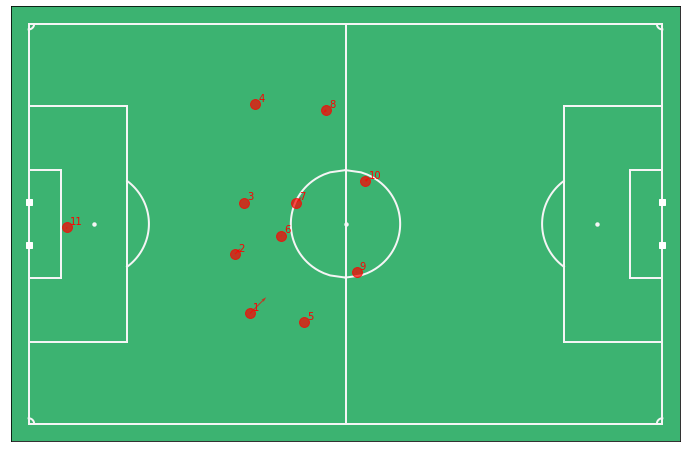

In [254]:
plot_frame(tracking_home, tracking_away, 100, include_player_velocities=True, annotate=True)